# Business Data Analytics - Exercise Regression Tutorial

This notebook is designed to illustrate the basic steps in a data science project. It is inspired by two notebooks from Kaggle, which is a platform that organises data science comptitions. Click [here](https://www.kaggle.com/code/abdelrahmantarek13/houseprice-step-by-step/notebook) and [here](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard) to see these notebooks.

## The CRISP-DM Process

> Cross-industry standard process for data mining, also known as CRISP-DM, is an open standard process model that describes common approaches used by data mining experts. It is the most widely-used analytics model.
> 
> -- Source: https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining

<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/b/b9/CRISP-DM_Process_Diagram.png" width="400" />
</p>

CRISP-DM breaks the process of data mining into six major phases:

- Business Understanding
- Data Understanding
- Data Preparation
- Modeling
- Evaluation
- Deployment

The sequence of the phases is not strict and moving back and forth between different phases is usually required. The arrows in the process diagram indicate the most important and frequent dependencies between phases. The outer circle in the diagram symbolizes the cyclic nature of data mining itself. A data mining process continues after a solution has been deployed. The lessons learned during the process can trigger new, often more focused business questions, and subsequent data mining processes will benefit from the experiences of previous ones.

**Disclaimer**: Because we are not solving a real-world data science project, we are skipping the **Business Understanding** and **Deployment Step**. However, in my experience, these steps are the most important ones to provide business value.

## Task Description: House Prices - Advanced Regression Techniques

This notebook follows the idea of the "House Prices - Advanced Regression Techniques" competition on Kaggle. However, the dataset for this competition has been compiled by Dean De Cock for use in data science education. It was designed after the Boston Housing dataset and is now considered a more modernized and expanded version of it. More details of this dataset are described in [Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf).

>**Goal**: It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 
>
>**Metric**: Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)
>
> -- description taken from [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)

## Install & import packages

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'c:\users\di872\desktop\lehre\bda\ss2022\übung\exercises\regression\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats  # statistical functions
import os  # access to operating system related functions

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# ml related libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from category_encoders.target_encoder import TargetEncoder

In [3]:
# plot inline
%matplotlib inline 

## Read data

In the next cell, we will download the data from an url and differentiate between the features X and the target variable y. Then we will create a train and test set.

In [4]:
# download original data
data = pd.read_csv("http://jse.amstat.org/v19n3/decock/AmesHousing.txt", sep='\t')

# get features and target
X, y = data.drop(['PID', 'Order', 'SalePrice'], axis=1), data['SalePrice']

# split into train and testset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
# read more about the data
with open('./data_description.txt', 'r') as file:
    description = file.read()
    
print(description)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## Data Understanding

### Gathering basic information about our data

In [6]:
# displaying first rows of data set
X_train.head(5)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
844,20,RL,68.0,9017,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
2730,150,RL,NaN,1700,Pave,NaN,Reg,HLS,AllPub,Inside,...,200,0,NaN,NaN,NaN,0,4,2006,WD,Normal
2793,20,RL,NaN,14781,Pave,NaN,IR2,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal
1187,20,RL,85.0,11050,Pave,NaN,Reg,Lvl,AllPub,Inside,...,192,0,NaN,GdWo,NaN,0,10,2008,WD,Family
2770,60,RL,65.0,12438,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal


In [7]:
# get information about data types
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197 entries, 844 to 860
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2197 non-null   int64  
 1   MS Zoning        2197 non-null   object 
 2   Lot Frontage     1828 non-null   float64
 3   Lot Area         2197 non-null   int64  
 4   Street           2197 non-null   object 
 5   Alley            154 non-null    object 
 6   Lot Shape        2197 non-null   object 
 7   Land Contour     2197 non-null   object 
 8   Utilities        2197 non-null   object 
 9   Lot Config       2197 non-null   object 
 10  Land Slope       2197 non-null   object 
 11  Neighborhood     2197 non-null   object 
 12  Condition 1      2197 non-null   object 
 13  Condition 2      2197 non-null   object 
 14  Bldg Type        2197 non-null   object 
 15  House Style      2197 non-null   object 
 16  Overall Qual     2197 non-null   int64  
 17  Overall Cond 

In [8]:
#check the numbers of samples and features
print("The X_train data size is : {} ".format(X_train.shape))
print("The X_test data size is : {} ".format(X_test.shape))

The X_train data size is : (2197, 79) 
The X_test data size is : (733, 79) 


### Plotting target variable

Since we are interested in forecasting the house price, we will first have a look at the distribution of the house prices themselves. The first plot shows the distribution of the sales price, while the second plot shows the probability of our data against the quantiles of a specified theoretical distribution. If our target variable followed a (perfect) normal distribution, all blue points would be on the red line. For more information on the second plot, click [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html).

c:\users\di872\desktop\lehre\bda\ss2022\übung\exercises\regression\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


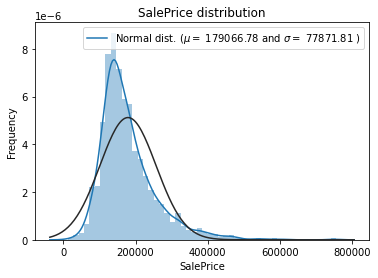

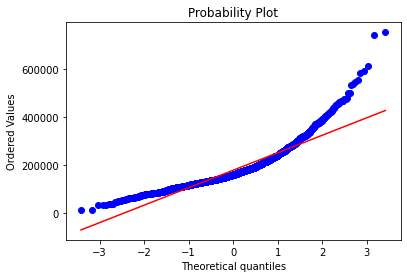

In [9]:
# visualize SalesPrice (target variable)
sns.distplot(y_train , fit=stats.norm)

#Now plot the distribution
(mu, sigma) = stats.norm.fit(y_train)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

#### Task: What are the conclusions that we can draw from these two plots?
Use the cell below to answer this question

The Sales Price distribution is not normally distributed. It has a "tail" on the right side of the distribution and is therefore right skewed.

### Visualize features

Now that we have a better understanding of what we are looking at, we can explore our features visually.

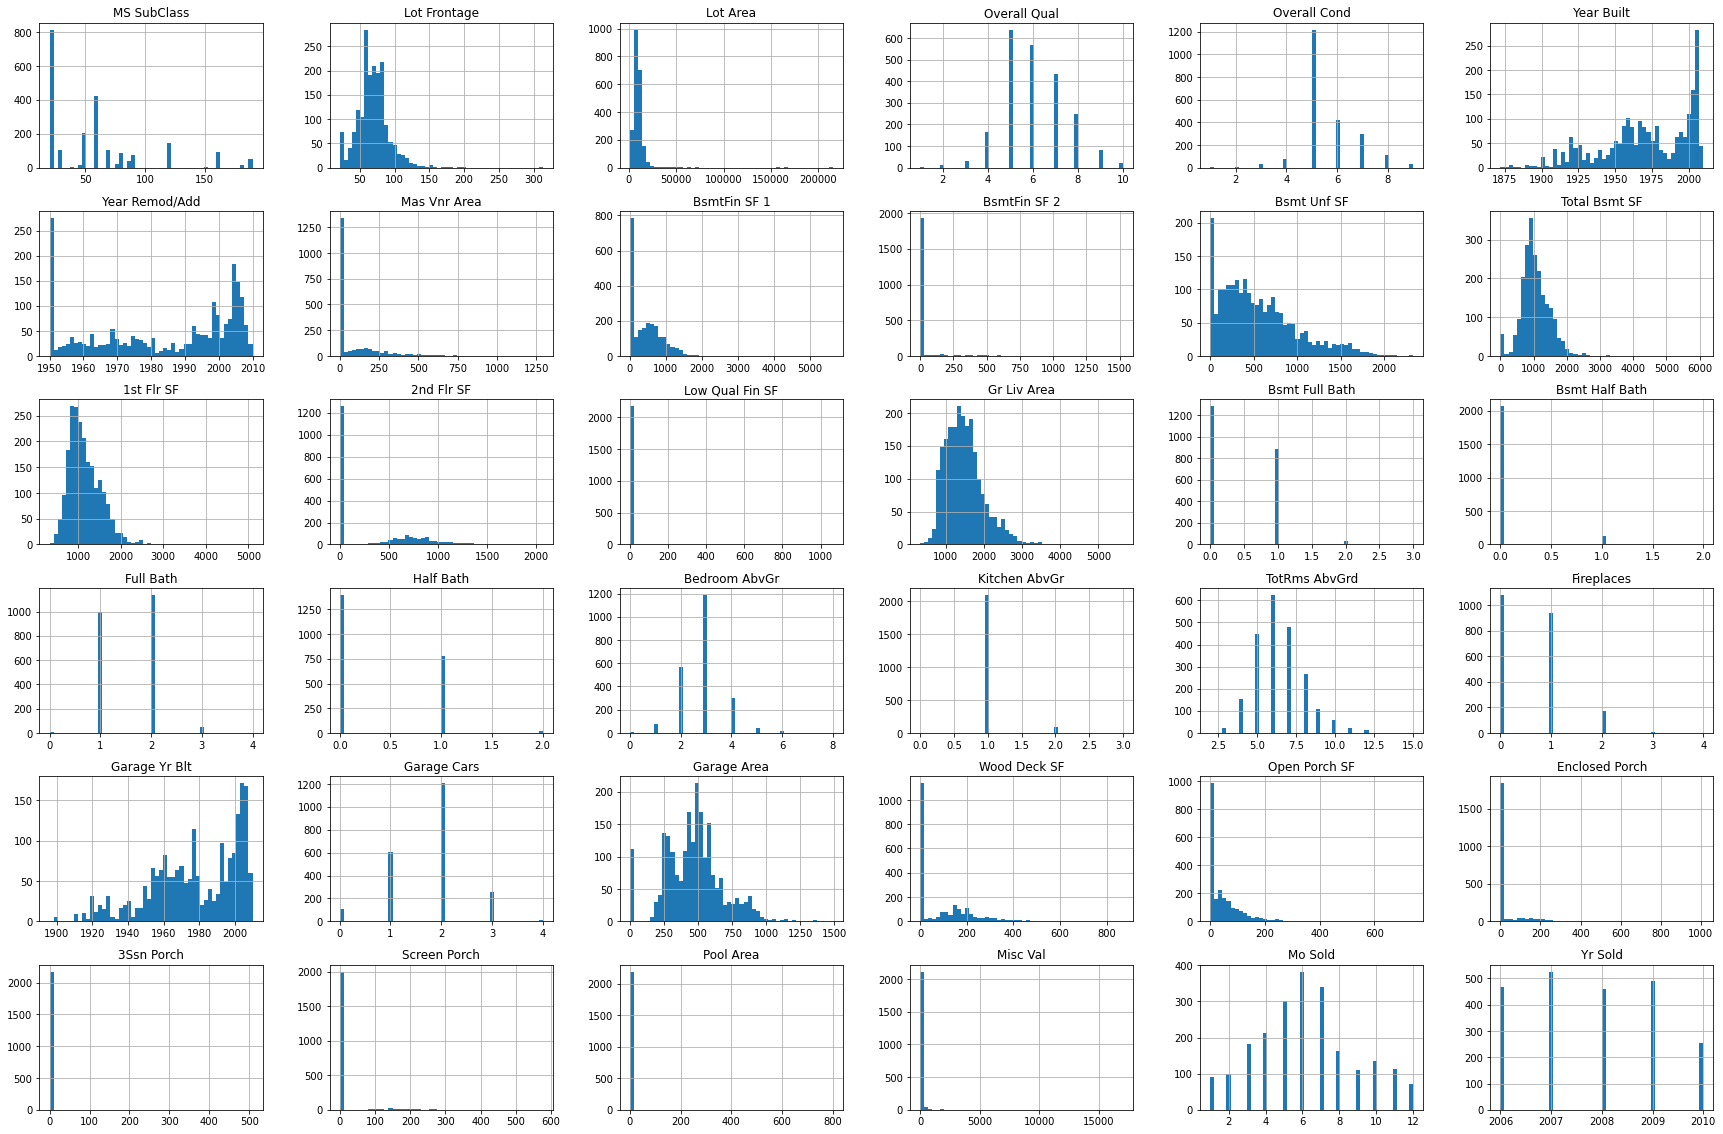

In [10]:
## visualizing numerical features
X_train.select_dtypes(np.number).hist(bins = 50,figsize =(30,20))
plt.show()

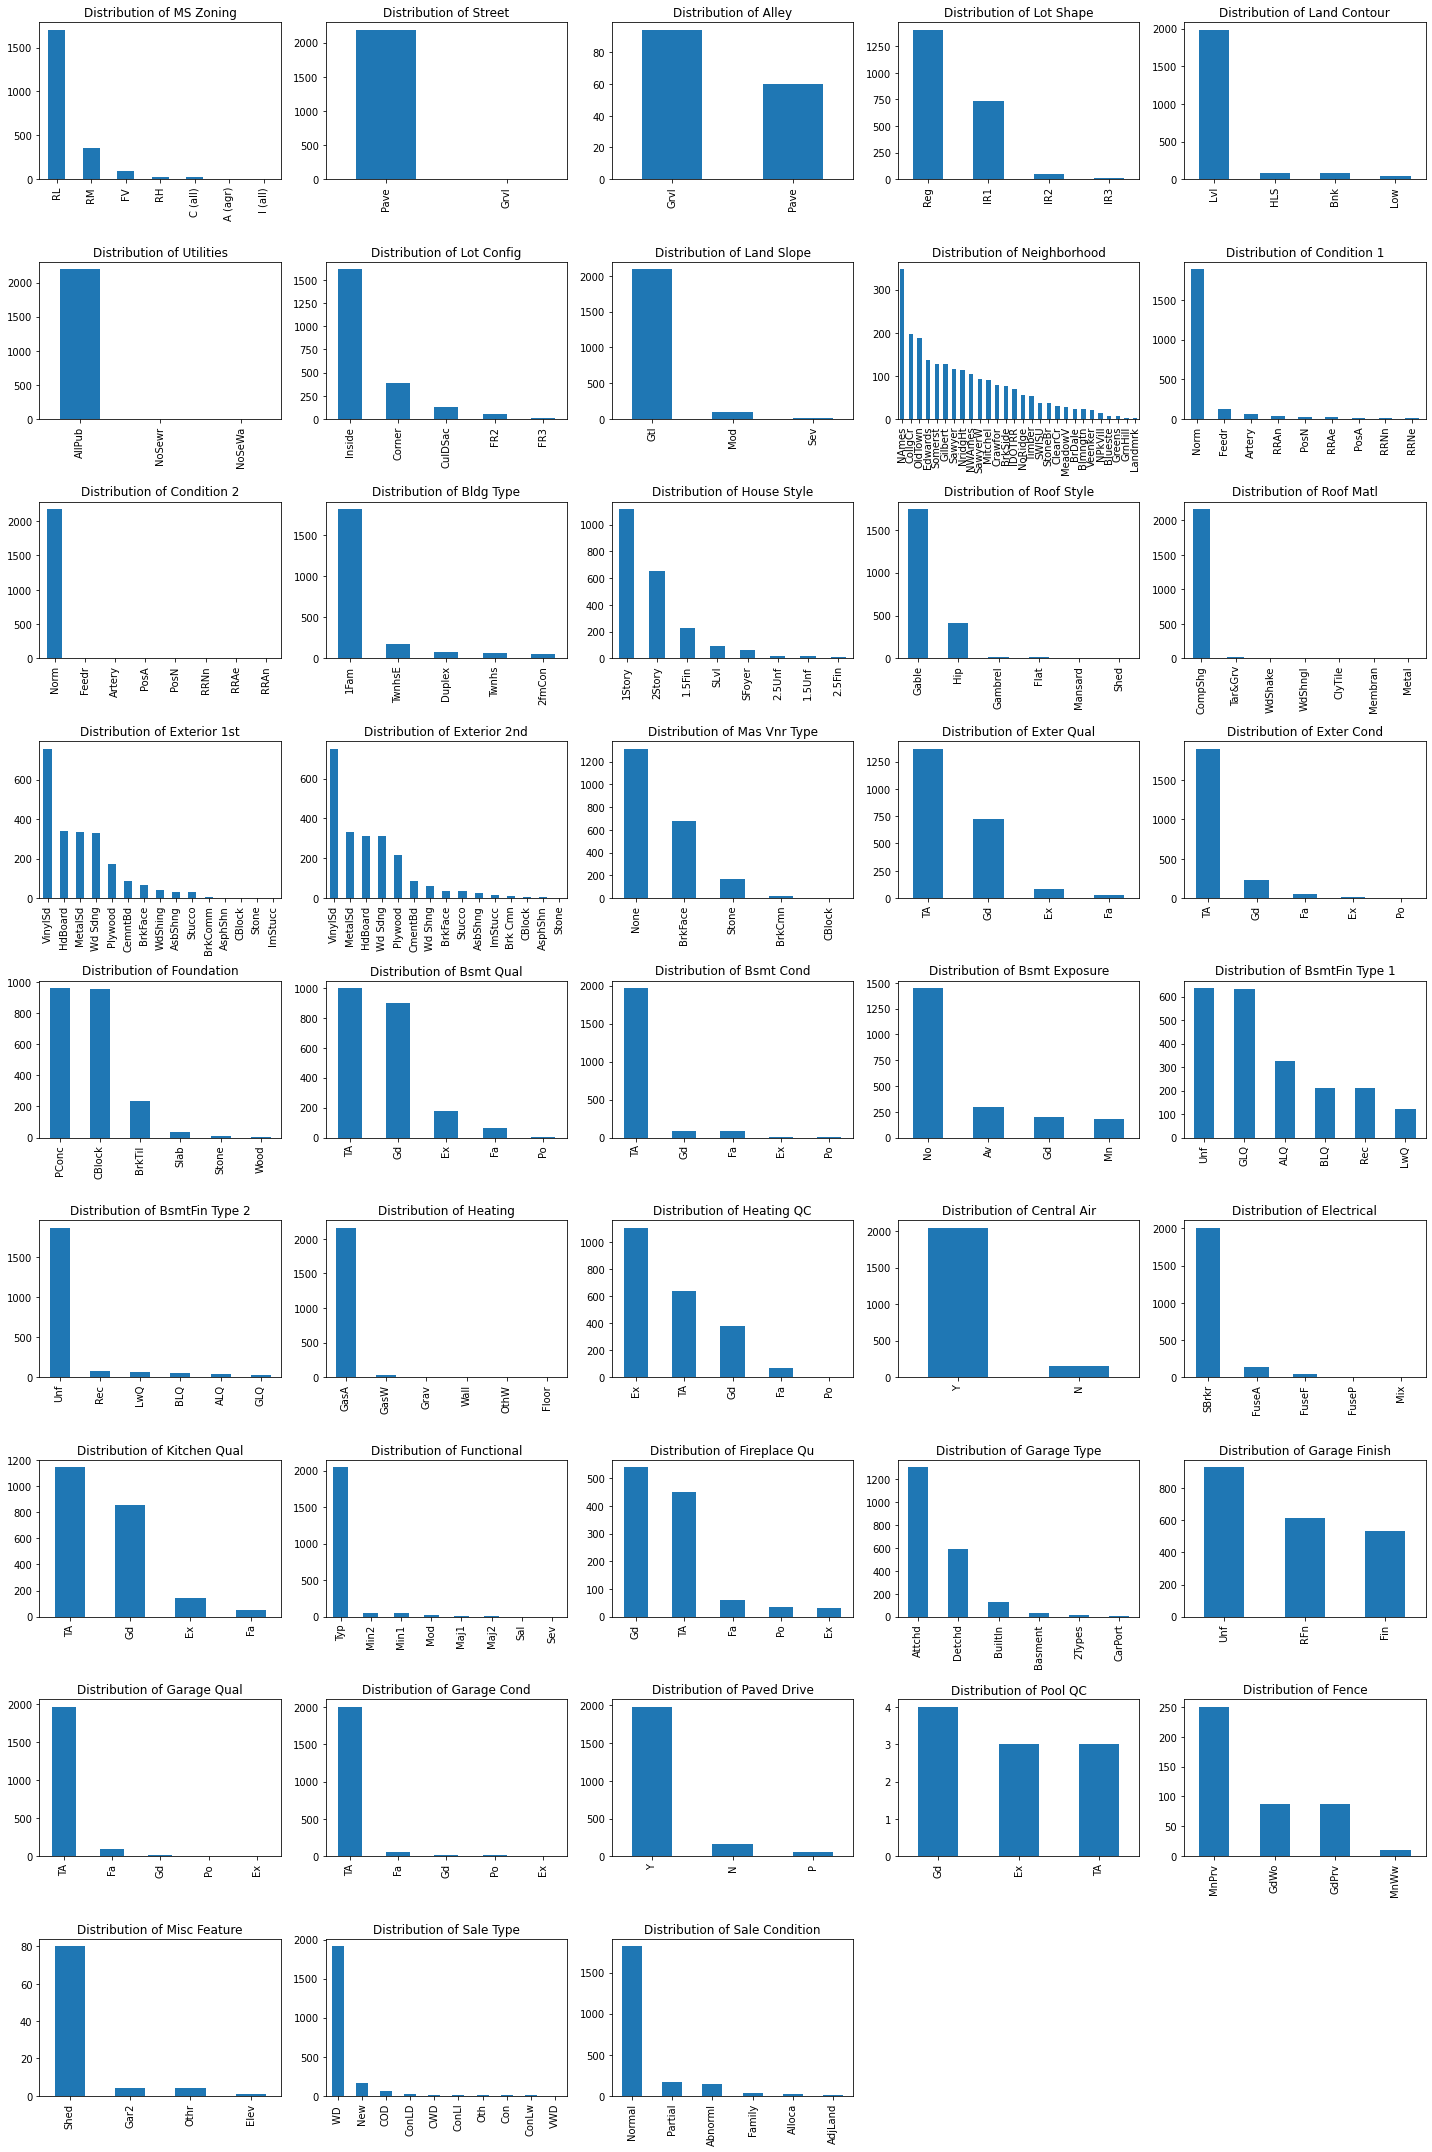

In [11]:
## visualizing categorical data
categorical_columns = X_train.select_dtypes('object').columns

n_columns = 5
n_rows = len(categorical_columns) // n_columns + 1

fig = plt.figure(figsize =(20,30))

for idx, column in enumerate(categorical_columns):
    
    ax = plt.subplot(n_rows, n_columns, idx + 1)
    X_train[column].value_counts().plot(kind='bar')
    ax.set_title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

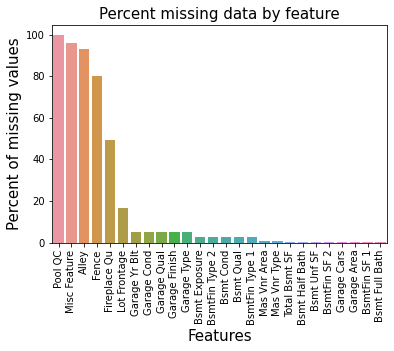

In [12]:
## visualize missing data ratio
X_train_na = (X_train.isnull().sum() / len(X_train)) * 100
X_train_na = X_train_na.drop(X_train_na[X_train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': X_train_na})
missing_data.head(20)

f, ax = plt.subplots()
plt.xticks(rotation='90')
sns.barplot(x=X_train_na.index, y=X_train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

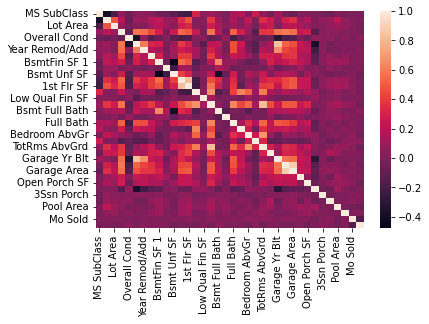

In [13]:
## visualize correlation
sns.heatmap(X_train.corr())
plt.show()

**Disclaimer**: usually, one would conduct an even more in-depth visual analysis of the dataset. For instance, one would investigate the relationship between all variables and the target variable. The Python package [Seaborn](https://seaborn.pydata.org/index.html) provides some good tutorials on data visualisation.  

## Data Preparation

Below is a brief, non-exhaustive overview of the most common data preparation steps.

### Imputing missing values

Imputing missing values often requires domain knowledge. In our dataset, for instance, there are a lot of columns, in which the missing value has a meaning and can therefore be meaningful encoded. If any value is missing at random, we can only make assumptions what this value should be encoded as. However, there are some advanced imputing techniques like k-nearest neighbors or an iterative imputer that try to make the best guess for us. If you want to read more about them, checkout sklearn's [documentation](https://scikit-learn.org/stable/modules/impute.html#impute).

#### Task: Please impute your missing values
Use the cells below to for your code

In [14]:
#### encode missing values as none
columns_none_encoded = [
    "Pool QC", "Misc Feature", "Alley", "Fence", "Fireplace Qu", 
    'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 
    'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 
    'BsmtFin Type 2','Mas Vnr Type', 'MS SubClass'
]

for column in columns_none_encoded:
    X_train[column] = X_train[column].fillna("None")
    X_test[column] = X_test[column].fillna("None")
    
#### encode missing values as 0
columns_zero_encoded = [
    'Garage Yr Blt', 'Garage Area', 'Garage Cars','BsmtFin SF 1', 
    'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF', 'Bsmt Full Bath', 
    'Bsmt Half Bath',"Mas Vnr Area",
]

for column in columns_zero_encoded:
    X_train[column] = X_train[column].fillna(0)
    X_test[column] = X_test[column].fillna(0)
    
#### estimate LotFrontage by looking at neighborhood
mapping = X_train.groupby('Neighborhood')['Lot Frontage'].agg('median').to_dict()
X_train['Lot Frontage'] = X_train.apply(lambda x: mapping.get(x['Neighborhood']), axis=1)
X_test['Lot Frontage'] = X_test.apply(lambda x: mapping.get(x['Neighborhood']), axis=1) 

#### encode all other features with either mode or median
numeric_columns = X_train.select_dtypes(np.number).columns.to_list()
categorical_columns = X_train.select_dtypes('object').columns.to_list()

for column in numeric_columns:
    numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train[column] = numeric_imputer.fit_transform(X_train[[column]])
    X_test[column] = numeric_imputer.transform(X_test[[column]])

for column in categorical_columns:
    categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    X_train[column] = categorical_imputer.fit_transform(X_train[[column]])
    X_test[column] = categorical_imputer.transform(X_test[[column]])

### Outlier removal

Some models, like linear regression, is sensitive to outliers. Hence, depending on your models requirements, you might want to exclude abnormal data points.

#### Task: Please investigate the above grade square feet area ('Gr Liv Area') for outliers
Use the cells below to for your code

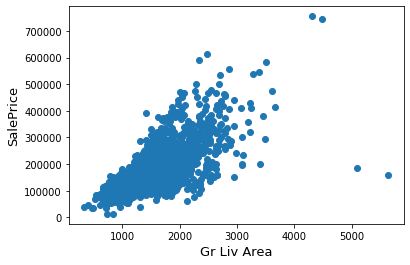

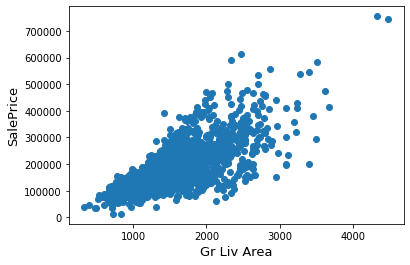

In [15]:
fig, ax = plt.subplots()
ax.scatter(x = X_train['Gr Liv Area'], y = y_train)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Gr Liv Area', fontsize=13)
plt.show()

#Deleting outliers
indices2drop = X_train[(X_train['Gr Liv Area']>4000) & (y_train<300000)].index
X_train = X_train.drop(indices2drop)
y_train = y_train.drop(indices2drop)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(X_train['Gr Liv Area'], y_train)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Gr Liv Area', fontsize=13)
plt.show()

### Feature engineering

In order to maximize our model's performance, we should also look into creating new features. This usually requires domain knowledge. However, there are also automated tools available. One of these tools is called featuretools. Click [here](https://github.com/alteryx/featuretools) for more information.

#### Task: Please think of a new feature and visualize if it has any correlation with the target variable
Use the cells below to for your code

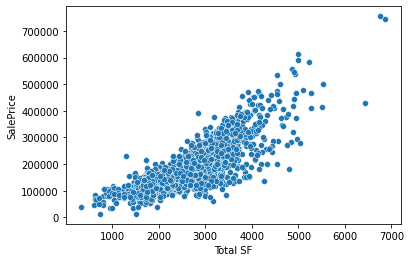

In [16]:
# Adding total sqfootage feature 
X_train['Total SF'] = X_train['Total Bsmt SF'] + X_train['1st Flr SF'] + X_train['2nd Flr SF']
X_test['Total SF'] = X_test['Total Bsmt SF'] + X_test['1st Flr SF'] + X_test['2nd Flr SF']

sns.scatterplot(x=X_train['Total SF'], y=y_train)
plt.show()

### Encoding of categorical features 

In sklearn, all machine learning algorithms assume that the categorical features are represented as numbers. This transformation can be done in many ways. Among the most popular is probably [one-hot-encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) or [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder). If you are interested in reading more about other, not so common encoding possibilities, check out the [category_encoder package](https://contrib.scikit-learn.org/category_encoders/). 

#### Task: Please encode your categorical features as numbers. Also think about numeric variables that are actually categorical.
Use the cells below to for your code

In [17]:
# transforming some numerical features that are actually categorical features
for column in ['MS SubClass', 'Overall Cond', 'Yr Sold', 'Mo Sold']:    
    X_train[column] = X_train[column].apply(str)
    X_test[column] = X_test[column].apply(str)

In [18]:
# encode categorical features with target encoding
categorical_columns = X_train.select_dtypes('object').columns.to_list()
encoder = TargetEncoder(cols=categorical_columns)

X_train = encoder.fit_transform(X=X_train, y=y_train)
X_test = encoder.transform(X=X_test)

### Perform feature selection / extraction
Usually, one would also perform feature selection or feature extraction. This will most likely increase the model performance if done well. However, since we are still in the explanatory phase, we will skip it. If you later want to interpret your model and its result, often feature selection is preferred. You can read more about feature selection [here](https://scikit-learn.org/stable/modules/feature_selection.html).   

### Transforming target variable

As shown earlier, the distribution of the target variable is skewed. In some cases, it makes sense to transform the distribution to make it resemble a normal distribution. However, this is not always a good idea and depends a lot on the error metric. If you want to read more about transforming the target variable, read Florian Wilhelm's [blogpost](https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/).

#### Task: Please transform your target variable and plot its distribution afterwards
Use the cells below to for your code

c:\users\di872\desktop\lehre\bda\ss2022\übung\exercises\regression\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


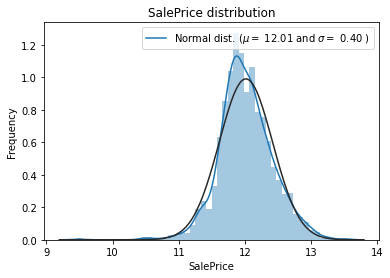

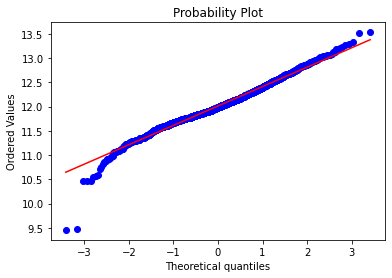

In [19]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

#Check the new distribution 
sns.distplot(y_train, fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(y_train)

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

## Modelling

#### Task: Please train at least two models.
An easy way to get started is to use models from [sklearn](https://scikit-learn.org/stable/index.html).
Use the cells below to for your code. 

In [20]:
# lasso regression
lasso = make_pipeline(RobustScaler(), Lasso())
lasso.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()), ('lasso', Lasso())])

In [21]:
# random forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

## Evaluation

#### Task: Please evaluate your models on the given error metric and use at least one naive benchmark
Use the cells below to for your code

In [25]:
# naive benchmark
y_pred_mean = np.ones_like(y_test) * y_train.mean()
mean_squared_error(y_pred_mean, y_test, squared=False)

0.42120039697974354

In [26]:
y_pred_rf = rf.predict(X_test)
mean_squared_error(y_pred_rf, y_test, squared=False)

0.1255297336828956

In [27]:
y_pred_lasso = lasso.predict(X_test)
mean_squared_error(y_pred_lasso, y_test, squared=False)

0.2942941431521429

#### Task: Please evaluate the residuals of your models. Do you consistently under- or overestimate the house prices?
Use the cells below to for your code

c:\users\di872\desktop\lehre\bda\ss2022\übung\exercises\regression\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


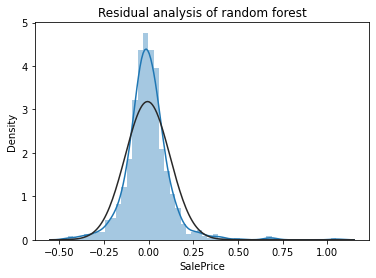

c:\users\di872\desktop\lehre\bda\ss2022\übung\exercises\regression\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


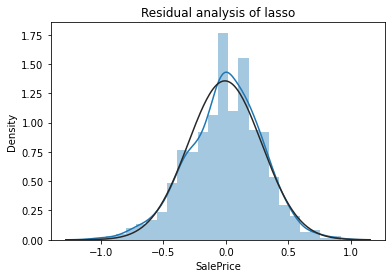

In [28]:
# residual analysis
for y_pred, title in zip([y_pred_rf, y_pred_lasso], ['random forest', 'lasso']):
    
    residuals = y_pred - y_test

    sns.distplot(residuals , fit=stats.norm)
    plt.title(f'Residual analysis of {title}')
    plt.show()

The distribution of the residuals follow a normal distribution and hence we do not consistently under- or overestimate the house prices

## Next Steps

#### Task: How can you improve our existing model?
Use the cell below to for your answer

To improve our model, we could do the following steps:

- create better features, e.g. by having a closer look at the data
- remove irrelevant features, e.g. by doing unsupervised feature extraction
- create an ensemble to improve predictions
- hyperparameter tuning
- ...